# Figure 8 - US frequency and sonophore radius dependent excitation thresholds

Compute (DC x amplitude) threshold curves of RS and LTS neurons for various sonophore radii and US frequencies, from SONIC model predictions.

### Matplotlib parameters

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'arial'

### Imports

In [2]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from PySONIC.utils import logger
from PySONIC.neurons import getPointNeuron
from utils import saveFigsAsPDF, plotThresholdAmps, cm2inch

Set high logging level to avoid extra logging

In [3]:
logger.setLevel(logging.ERROR)

### Plot parameters

In [9]:
figindex = 8
figsize=cm2inch(15, 12)
fs = 14
cmap = plt.get_cmap('tab20c').colors
figs = {}

### Simulation parameters

In [10]:
a = 32e-9       # m
Fdrive = 500e3  # Hz
tstim = 1.0     # s
toffset = 0.0   # s
PRF = 100.0     # s
cov = 1.0
DCs = np.arange(1, 101) * 1e-2

neurons = ['RS', 'LTS']
pneurons = [getPointNeuron(x) for x in neurons]

## Panel A: sonophore radius-dependent threshold curves

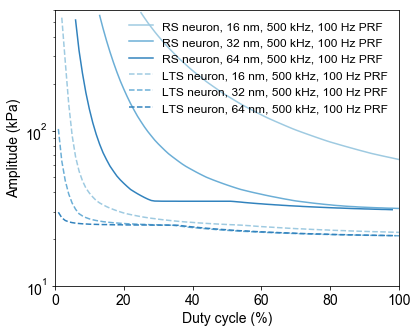

In [11]:
radii = np.array([16, 32, 64]) * 1e-9  # m
colors = cmap[:3][::-1]
fig = plotThresholdAmps(pneurons, radii, Fdrive, tstim, toffset, PRF, DCs, cov, colors=colors, fs=fs, figsize=figsize)
figs['a'] = fig

## Panel B: frequency-dependent threshold curves

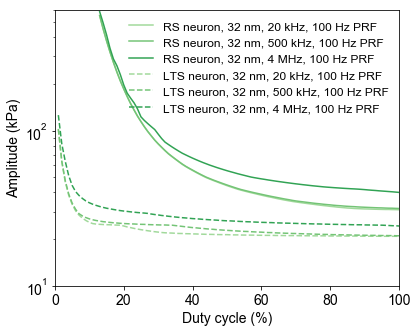

In [12]:
freqs = np.array([20, 500, 4000]) * 1e3  # Hz
colors = cmap[8:11][::-1]
fig = plotThresholdAmps(pneurons, a, freqs, tstim, toffset, PRF, DCs, cov, colors=colors, fs=fs, figsize=figsize)
figs['b'] = fig

### Save figure panels

Save figure panels as **pdf** in the *figs* sub-folder:

In [13]:
saveFigsAsPDF(figs, figindex)